## Extract TLD in ont Fingerprinting scripts

This notebook extracts the TLDs for script_url and location in Font Fingerprinting scripts. The heuristics to find out the Font Fingerprinting scripts is directly taken from [2019_03_willougr_fingerprinting_implementation_sixth_sense/Font Fingerprinting Heuristics](https://github.com/mozilla/overscripted/blob/master/analyses/2019_03_willougr_fingerprinting_implementation_sixth_sense/Font%20Fingerprinting%20Heuristics.ipynb).

In [49]:
import dask.dataframe as dd
import pandas as pd
import re
import json

from dask.distributed import Client, progress
from collections import defaultdict, Counter

DATA_DIR = 'YOUR DATA DIRECTORY HERE'
DATA_DIR_FULL = '/home/soumya/Dataset/sample_0.parquet'
Client()

/home/soumya/.conda/envs/overscripted/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:43797 Dashboard: http://127.0.0.1:38401/status,Cluster Workers: 4 Cores: 12 Memory: 8.25 GB


## Setup

In [4]:
df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol', 'value', 'location', 'argument_0'])
df.head()

,script_url,symbol,value,location,argument_0
call_id,,,,,
1_00006011493ed94fb8010cead84ee610cdbece5de961abe96f0cba54.json__0,https://vk.com/js/api/xdm.js?1449919642,window.name,fXDcab74,https://vk.com/widget_comments.php?app=2297596...,None
1_00006011493ed94fb8010cead84ee610cdbece5de961abe96f0cba54.json__1,https://vk.com/js/api/xdm.js?1449919642,window.name,fXDcab74,https://vk.com/widget_comments.php?app=2297596...,None
1_00006011493ed94fb8010cead84ee610cdbece5de961abe96f0cba54.json__2,https://vk.com/js/al/aes_light.js?592436914,window.navigator.userAgent,Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko...,https://vk.com/widget_comments.php?app=2297596...,None
1_00006b1ad6ce7a5b2b81a8ef96f0778853ea6d81a97693d85a52790c.json__0,https://cpro.baidustatic.com/cpro/ui/noexpire/...,window.navigator.userAgent,Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko...,https://pos.baidu.com/s?hei=70&wid=670&di=u313...,None
1_0000813d43acf1fe219ada01597cfb1d5dc9c12b61f343c6cfac362b.json__0,https://apis.google.com/js/plusone.js?_=151338...,window.document.cookie,_ga=GA1.2.1529583939.1513387469; _gid=GA1.2.17...,http://serienjunkies.org/smilf/smilf-season-1-...,None


## Candidate URLs for 'CanvasRenderingContext2D.font'

In [8]:
font_df_sixth_sense = df[df.symbol == 'CanvasRenderingContext2D.font']
font_df_sixth_sense = font_df_sixth_sense[['value', 'script_url', 'location']]
font_df_sixth_sense = font_df_sixth_sense.drop_duplicates().persist()
progress(font_df_sixth_sense, notebook=False)

In [9]:
font_df_sixth_sense = font_df_sixth_sense.compute()
font_df_sixth_sense.head()

,value,script_url,location
call_id,,,
1_00022de65942197e3855f68b373c5a2710eefe66945e40063c30419f.json__268,11pt Arial,https://www.coches.net/ztkieflaaxcvaiwh121837.js,https://www.coches.net/fiat/segunda-mano/
1_00022de65942197e3855f68b373c5a2710eefe66945e40063c30419f.json__271,18pt Arial,https://www.coches.net/ztkieflaaxcvaiwh121837.js,https://www.coches.net/fiat/segunda-mano/
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__353,7px 'sans-serif',http://static.mvideo.ru/media/js/mvideo.js?v0.7,http://www.mvideo.ru/aksessuary-dlya-avtomobil...
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__358,7px 'Abadi MT Condensed',http://static.mvideo.ru/media/js/mvideo.js?v0.7,http://www.mvideo.ru/aksessuary-dlya-avtomobil...
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__363,7px 'Adobe Fan Heiti Std',http://static.mvideo.ru/media/js/mvideo.js?v0.7,http://www.mvideo.ru/aksessuary-dlya-avtomobil...


In [10]:
%%time

num_fonts_sixth_sense = defaultdict(set)
    
for index, row in font_df_sixth_sense.iterrows():
    num_fonts_sixth_sense[(row.script_url, row.location)].add(row.value)

CPU times: user 5.22 s, sys: 143 ms, total: 5.37 s
Wall time: 5.21 s


In [11]:
font_urls_not_enough_sixth_sense = [x for x, font_set in num_fonts_sixth_sense.items() if len(font_set) < 50]
font_urls_candidates_sixth_sense = [x for x, font_set in num_fonts_sixth_sense.items() if len(font_set) >= 50]

In [12]:
print('# of unique tuples (script_url, location) with 50 or more calls:', len(font_urls_candidates_sixth_sense))
print('# of unique tuples (script_url, location) with less than 50:', len(font_urls_not_enough_sixth_sense))

# of unique tuples (script_url, location) with 50 or more calls: 227
# of unique tuples (script_url, location) with less than 50: 5918


In [13]:
with open('not_font_fingerprinting_1.json', 'w') as f:
    f.write(json.dumps(list(set([script_url for script_url, location in font_urls_not_enough_sixth_sense]))))

## Candidate URLs for 'CanvasRenderingContext2D.measureText'

In [14]:
measure_text_df_sixth_sense = df[df.symbol == 'CanvasRenderingContext2D.measureText']
measure_text_df_sixth_sense = measure_text_df_sixth_sense[['argument_0', 'script_url', 'location']]
measure_text_df_sixth_sense['to_count'] = 1
measure_text_df_sixth_sense = measure_text_df_sixth_sense.groupby(['argument_0', 'script_url', 'location']).count().persist()
progress(measure_text_df_sixth_sense, notebook=False)

In [15]:
measure_text_df_sixth_sense = measure_text_df_sixth_sense.compute()
measure_text_df_sixth_sense = measure_text_df_sixth_sense.reset_index('argument_0', drop=True)
measure_text_df_sixth_sense.head()

to_count
script_url                                         location                                  
http://sspy-up.gov.in/fusioncharts/js/fusioncha... http://sspy-up.gov.in/index.aspx        10
                                                   http://sspy-up.gov.in/index.aspx        10
                                                   http://sspy-up.gov.in/index.aspx         2
                                                   http://sspy-up.gov.in/index.aspx         2
                                                   http://sspy-up.gov.in/index.aspx         2

In [16]:
measure_text_not_enough_df_sixth_sense = measure_text_df_sixth_sense[measure_text_df_sixth_sense['to_count'] < 50]

In [17]:
measure_text_df_sixth_sense = measure_text_df_sixth_sense[measure_text_df_sixth_sense['to_count'] >= 50]

In [18]:
measure_text_urls_candidates_sixth_sense = set(measure_text_df_sixth_sense.index.tolist())
measure_text_urls_not_enough_sixth_sense = set(measure_text_not_enough_df_sixth_sense.index.tolist())

In [19]:
print('# of unique tuples (script_url, location) with 50 or more calls:', len(measure_text_urls_candidates_sixth_sense))
print('# of unique tuples (script_url, location) with less than 50:', len(measure_text_urls_not_enough_sixth_sense))

# of unique tuples (script_url, location) with 50 or more calls: 245
# of unique tuples (script_url, location) with less than 50: 250


In [20]:
with open('not_font_fingerprinting_2.json', 'w') as f:
    f.write(json.dumps(list(set([script_url for script_url, location in measure_text_urls_not_enough_sixth_sense]))))

## Cross reference lists

In [21]:
font_urls_candidates_sixth_sense = set(font_urls_candidates_sixth_sense)

all_candidate_urls_sixth_sense = font_urls_candidates_sixth_sense | measure_text_urls_candidates_sixth_sense
canvas_font_fp_urls_sixth_sense = font_urls_candidates_sixth_sense & measure_text_urls_candidates_sixth_sense

print('# of unique tuples (script_url, location) meeting both criteria:', len(canvas_font_fp_urls_sixth_sense))
print('# of unique tuples (script_url, location) that only meet one criteria:', len(all_candidate_urls_sixth_sense - canvas_font_fp_urls_sixth_sense))

# of unique tuples (script_url, location) meeting both criteria: 199
# of unique tuples (script_url, location) that only meet one criteria: 74


In [22]:
with open('not_font_fingerprinting_3.json', 'w') as f:
    f.write(json.dumps(list(set([script_url for script_url, location in (all_candidate_urls_sixth_sense - canvas_font_fp_urls_sixth_sense)]))))

## Save Candidate URLs

In [23]:
with open('font_fingerprinting.json', 'w') as f:
    f.write(json.dumps(list(set([script_url for script_url, location in canvas_font_fp_urls_sixth_sense]))))

## Find Locations

In [24]:
with open('font_fingerprinting.json', 'r') as f:
    font_fp_urls = json.load(f)
    
print(len(font_fp_urls), '== 1387')

165 == 1387


In [25]:
df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'location'])

In [26]:
df_locs = df[df.script_url.isin(font_fp_urls)]
locs = df_locs.location.unique().persist()
progress(locs, notebook=False)

In [27]:
print('# of locations that call audio fingerprinting scripts:', len(locs))

# of locations that call audio fingerprinting scripts: 229


In [28]:
font_fp_urls[0:5]

['https://m.stripe.network/inner.html#referrer=&title=Oops%20%7C%20Warrior%20Forum%20-%20The%20%231%20Internet%20Marketing%20Forum%20%26%20Marketplace&url=https%3A%2F%2Fwww.warriorforum.com%2Fhigh-voltage-video-forum%2F&muid=cb84799e-2cec-4091-b638-24dbd9b2f90e&sid=f1b662e6-3eb6-47cd-8494-3c54463f1cd5&preview=false&',
 'https://m.stripe.network/inner.html#referrer=&title=Workplace%20Harassment%20Training%20for%20Employees%20Course%20-%20Online%20Video%20Lessons%20%7C%20Study.com&url=https%3A%2F%2Fstudy.com%2Facademy%2Fcourse%2Fworkplace-harassment-training-for-employees.html&muid=eae1878c-4491-4f63-b641-78c7ac614f21&sid=f5e399fc-96b4-4ac4-b452-7eba7f70f01c&preview=false&',
 'https://t1.musthird.com/fp/check.js;CIS3SID=3BC39B2D37C93E953A0735D3AFCCBD4F?org_id=kfgn8s24&session_id=1513453722--4397116f1851ce69f7181ea3&nonce=a3c9b1ee33c05e98&pageid=1',
 'https://m.stripe.network/inner.html#referrer=&title=Quantitative%20Analyst%20with%20R%20Track%20%7C%20DataCamp&url=https%3A%2F%2Fwww.dataca

In [29]:
len(font_fp_urls)

165

In [30]:
location=locs.compute()
location[0:10]

0    https://m.stripe.network/inner.html#referrer=&...
1    https://m.stripe.network/inner.html#referrer=&...
2       https://phimbathu.com/tag/chau-tinh-tri-7.html
3    https://www.macys.com/shop/kids-clothes/baby-c...
4    https://www.llbean.com/llb/shop/514368?nav=ftl...
5    https://m.stripe.network/inner.html#referrer=&...
6    https://www.britishairways.com/travel/low-pric...
7    https://m.stripe.network/inner.html#url=https%...
8                http://kenh14.vn/sport/hau-truong.chn
9    https://m.stripe.network/inner.html#referrer=&...
Name: location, dtype: object

## Extract TLD for script_url

In [31]:
import tldextract
opsuffix=[]
opurls=[]
for i in range(len(font_fp_urls)):
    opurls.append(tldextract.extract(font_fp_urls[i]))
    opsuffix.append(opurls[i].suffix)
print(opsuffix)

['network', 'network', 'com', 'network', 'network', 'com', 'com', 'network', 'network', 'com', 'network', 'network', 'network', 'network', 'network', 'network', 'com', 'com', 'network', 'network', 'network', 'com', 'com', 'com', 'network', 'network', 'network', 'com', 'network', 'network', 'network', 'com', 'vn', 'network', 'network', 'network', 'network', 'network', 'network', 'network', 'com', 'vn', 'network', 'network', 'com', 'network', 'network', 'network', 'com', 'com', 'network', 'network', 'network', 'net', 'network', 'network', 'network', 'network', 'com', 'net', 'network', 'com', 'com', 'com', 'network', 'network', 'network', 'network', 'network', 'network', 'network', 'network', 'network', 'com', 'com', 'network', 'network', 'com', 'network', 'com', 'network', 'network', 'com', 'network', 'com', 'network', 'network', 'network', 'com', 'network', 'network', 'network', 'net', 'com', 'network', 'network', 'com', 'com', 'network', 'network', 'com', 'network', 'com', 'net', 'netw

## Extract TLD for location

In [33]:
opsuffix_locs=[]
opurls_locs=[]
for i in range(len(locs)):
    opurls_locs.append(tldextract.extract(location[i]))
    opsuffix_locs.append(opurls_locs[i].suffix)
print(opsuffix_locs[0:20])

['network', 'network', 'com', 'com', 'com', 'network', 'com', 'network', 'vn', 'network', 'vn', 'network', 'network', 'network', 'network', 'com', 'com.tr', 'net', 'network', 'network']


## Frequency of each TLD for script_url

In [34]:
import collections
for i in range(len(opsuffix)):
    counter_script_url=collections.Counter(opsuffix)
print(counter_script_url)

Counter({'network': 110, 'com': 49, 'net': 4, 'vn': 2})


In [36]:
len(counter_script_url)

4

In [47]:
# Store in a json file
with open('font_script_url.json', 'w') as f:
    f.write(json.dumps(counter_script_url))


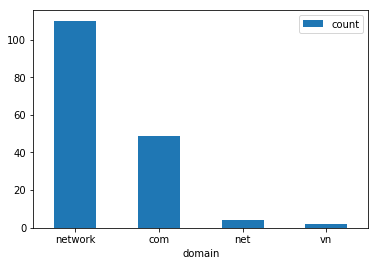

In [50]:
# Arange in descending order    
c=Counter(counter_script_url)
counter_script_url=dict(c.most_common())
#Convert to list for plotting
domain=list(counter_script_url.keys())
count=list(counter_script_url.values())

dfplot = pd.DataFrame({'domain':domain, 'count':count})
ax = dfplot.plot.bar(x='domain', y='count', rot=0)

## Frequency of each TLD for location

In [40]:
for i in range(len(locs)):
    counter_location=collections.Counter(opsuffix_locs)
print(counter_location)

Counter({'network': 110, 'com': 73, 'vn': 16, 'net': 16, 'com.vn': 4, 'com.tr': 2, 'in': 2, 'gr': 1, 'eu': 1, 'com.ar': 1, 'fi': 1, 'es': 1, 'com.uy': 1})


In [41]:
# Store in a json file
with open('font_location.json', 'w') as f:
    f.write(json.dumps(counter_location)) 

In [42]:
len(counter_location)

13

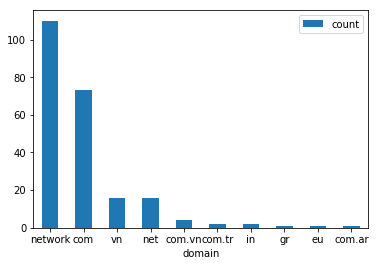

In [52]:
# Arange in descending order    
c=Counter(counter_location)
counter_location=dict(c.most_common())
#Convert to list for plotting
domain=list(counter_location.keys())
count=list(counter_location.values())

dfplot = pd.DataFrame({'domain':domain[0:10], 'count':count[0:10]})
ax = dfplot.plot.bar(x='domain', y='count', rot=0)